In [2]:
import os
import math
import random

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_v3 import preprocess_input
from keras.regularizers import l2
tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.10.0


In [3]:
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [4]:
import warnings
import logging

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)
tf.get_logger().setLevel('INFO')
tf.autograph.set_verbosity(0)

tf.get_logger().setLevel(logging.ERROR)
tf.get_logger().setLevel('ERROR')
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [5]:

labels = ['Species1',       # 0
          'Species2',       # 1
          'Species3',       # 2
          'Species4',       # 3
          'Species2',       # 4
          'Species2',       # 5
          'Species7',       # 6
          'Species8',       # 7
          ]

In [6]:
# Splitting the main dataset into train and val
dataset_dir = 'datasetNoTest'

if not(os.path.exists('datasetNoTest')) :
    print('splitting')
    splitfolders.ratio('dataset', output='datasetNoTest', seed=seed, ratio=(0.8, 0.2))

# Setting dataset directories
training_dir = os.path.join(dataset_dir, 'train')
validation_dir = os.path.join(dataset_dir, 'val')

In [7]:
img_w = 96
img_h = 96
input_shape = (96, 96, 3)
classes = 8

patience_epochs = 8
batch_size = 24

last_nonTrainable_layer = 207

In [8]:
# This calculate the weights for all the classes
# by counting the number of images for each class
# and dividing by the number of total images
category_weight = {}
elements_per_class = {}
i=0
path = "datasetNoTest/train"
dirs = os.listdir(path)
for d in dirs:
    category_weight[i] = 0.0
    elements_per_class[i] = len(os.listdir(path+"/"+d))
    i=i+1

total_images = sum(elements_per_class.values())

for i in category_weight.keys():
    category_weight[i] = total_images / (classes * elements_per_class[i])
    
print(category_weight)

{0: 2.389358108108108, 1: 0.8320588235294117, 2: 0.8583131067961165, 3: 0.8667279411764706, 4: 0.8340212264150944, 5: 1.9978813559322033, 6: 0.8243006993006993, 7: 0.8709975369458128}


In [9]:
# While creating the data generator, split in train and test sets

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an instance of ImageDataGenerator for training
datagen = ImageDataGenerator(#rescale=1./255,
    height_shift_range=50,
    width_shift_range=50,                                   
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True, 
    fill_mode='reflect',
    )

train_generator = datagen.flow_from_directory(
    training_dir,
    target_size=(96, 96),
    color_mode='rgb',
    batch_size=256,
    class_mode='categorical',
    shuffle=True,
    ) # set as training data

validation_generator = datagen.flow_from_directory(
    validation_dir, 
    target_size=(96, 96),
    color_mode='rgb',
    batch_size=256,
    class_mode='categorical',
    shuffle=False,
    ) 

Found 2829 images belonging to 8 classes.
Found 713 images belonging to 8 classes.


In [10]:
# check labels (keep lexicographical order)
print("Assigned labels")
print(train_generator.class_indices)
print()
print("Target classes")
print(train_generator.classes)

Assigned labels
{'Species1': 0, 'Species2': 1, 'Species3': 2, 'Species4': 3, 'Species5': 4, 'Species6': 5, 'Species7': 6, 'Species8': 7}

Target classes
[0 0 0 ... 7 7 7]


In [11]:
def get_next_batch(generator):
  batch = next(generator)

  image = batch[0]
  target = batch[1]

  print("(Input) image shape:", image.shape)
  print("Target shape:",target.shape)

  # Visualize only the first sample
  image = image[0]
  target = target[0]
  target_idx = np.argmax(target)
  print()
  print("Categorical label:", target)
  print("Label:", target_idx)
  print("Class name:", labels[target_idx])
  fig = plt.figure(figsize=(6, 4))
  plt.imshow(np.uint8(image))

  return batch

(Input) image shape: (256, 96, 96, 3)
Target shape: (256, 8)

Categorical label: [0. 0. 0. 1. 0. 0. 0. 0.]
Label: 3
Class name: Species4


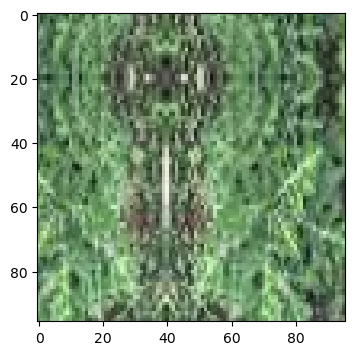

In [12]:
# Get a sample from dataset and show info
_ = get_next_batch(train_generator)

In [14]:
# Download and plot the VGG16 model
supernet = tfk.applications.VGG19(
    include_top=False,    # we remove the classifier and keep only the feature extraction part
    weights="imagenet",   
    input_shape=(96,96,3)
)
supernet.summary()
tfk.utils.plot_model(supernet)

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [15]:
#import regularizers
from tensorflow.keras import regularizers
# Use the supernet as feature extractor
supernet.trainable = False      # the optimizer won't consider the parameters of vgg gduring the optimization

inputs = tfk.Input(shape=(96,96,3))
x = tfkl.Resizing(96, 96, interpolation="bicubic")(inputs)        # why resize? to what dimension?
x = supernet(x)
# beginning of the part we are going to train
x = tfkl.GlobalAveragePooling2D(name='GlobalPooling')(x)
x = tfkl.Dropout(0.3, seed=seed)(x)
x = tfkl.Dense(
    64, 
    kernel_regularizer=regularizers.l2(0.01),
    activation='relu',
    kernel_initializer = tfk.initializers.GlorotUniform(seed))(x)
x = tfkl.Dropout(0.3, seed=seed)(x)
x = tfkl.Dense(
    32,
    kernel_regularizer=regularizers.l2(0.01),
    activation='relu',
    kernel_initializer = tfk.initializers.GlorotUniform(seed))(x)
x = tfkl.Dropout(0.3, seed=seed)(x)
outputs = tfkl.Dense(
    8, 
    activation='softmax',
    kernel_initializer = tfk.initializers.GlorotUniform(seed))(x)
# end of the part we are going to train - VGG remains fixed

# Connect input and output through the Model class
tl_model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

# Compile the model
tl_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')
tl_model.summary()
tfk.utils.plot_model(tl_model)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 resizing (Resizing)         (None, 256, 256, 3)       0         
                                                                 
 vgg19 (Functional)          (None, 8, 8, 512)         20024384  
                                                                 
 GlobalPooling (GlobalAverag  (None, 512)              0         
 ePooling2D)                                                     
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 64)                32832     
                                                             

In [17]:
d_class_weights = {
    0: 2.389358108108108, 
    1: 0.8320588235294117, 
    2: 0.8583131067961165, 
    3: 0.8667279411764706, 
    4: 0.8340212264150944, 
    5: 1.9978813559322033, 
    6: 0.8243006993006993, 
    7: 0.8709975369458128
}


In [ ]:
# Train the model
tl_history = tl_model.fit(
    x = train_generator,
    class_weight = d_class_weights,
    batch_size = 256,
    epochs = 90,
    validation_data = validation_generator,
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=7, restore_best_weights=True)]
).history

Epoch 1/90
 1/12 [=>............................] - ETA: 1:57 - loss: 12.9524 - accuracy: 0.1538

In [ ]:
# Save the best model
tl_model.save('TransferLearningModel')

In [1]:
# Re-load the model after transfer learning
ft_model = tfk.models.load_model('TransferLearningModel')
ft_model.summary()

NameError: name 'tfk' is not defined

In [ ]:

ft_model.get_layer('vgg19').trainable = True
for i, layer in enumerate(ft_model.get_layer('vgg19').layers):
   print(i, layer.name, layer.trainable)

In [ ]:

for i, layer in enumerate(ft_model.get_layer('vgg19').layers[:18]):
  layer.trainable=False
for i, layer in enumerate(ft_model.get_layer('vgg19').layers):
   print(i, layer.name, layer.trainable)
ft_model.summary()

In [ ]:
ft_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-4), metrics='accuracy')

In [ ]:
# Fine-tune
ft_history = ft_model.fit(
    x = train_generator,
    class_weight = d_class_weights,
    batch_size = 256,
    epochs = 200,
    validation_data = validation_generator,
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True)]
).history

In [ ]:
ft_model.save('FineTuningModel')
del ft_model